In [1]:
%load_ext autoreload
%autoreload 1
import os
import pandas as pd
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch import nn
import torch
import models
%aimport models
import model_utils
%aimport model_utils
import custom_dataset
%aimport custom_dataset
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset, Subset, random_split
import time

In [2]:
actions = ['move_left', 'move_right', 'jump', 'attack', 'dash', 'spell', 'focus']

# Generate dataset

In [3]:
files = [f.split('.')[0] for f in os.listdir('./data') if f.split('.')[1] == 'jsonl' and 'Mantis' in f.split('.')[0]]
files.sort()

len(files)

10

In [4]:
df = []
video_df = cv2.VideoWriter('./data/dataset-mantis.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (224, 224))
for i, name in enumerate(files):
    j = 0
    video = cv2.VideoCapture(f'./data/{name}.mp4')
    with open(f"./data/{name}.jsonl", "r") as file:
        for line in file:
            # Actions
            jsonl = json.loads(line.replace('infinity', 'null'))
            jsonl['i'] = i
            jsonl['j'] = j
            j += 1
            df.append(jsonl)
            # Frames
            _, frame = video.read()
            assert(_)
            #if i == 0 and j > 2:
            resized_frame = cv2.resize(frame, (224, 224))
            video_df.write(resized_frame)
video_df.release()
len(df) # 15140

19580

In [5]:
df = pd.DataFrame(df)
df.to_csv('./data/dataset-mantis.csv')
df

frame  move_left  move_right     up   down   jump  attack   dash  \
0          1      False       False  False  False  False   False  False   
1          2      False       False  False  False  False   False  False   
2          3      False       False  False  False  False   False  False   
3          4      False       False  False  False  False   False  False   
4          5      False       False  False  False  False   False  False   
...      ...        ...         ...    ...    ...    ...     ...    ...   
19575   1558      False       False  False  False  False   False  False   
19576   1559      False       False  False  False  False   False  False   
19577   1560      False       False  False  False  False   False  False   
19578   1561      False       False  False  False  False   False  False   
19579   1562      False       False  False  False  False   False  False   

       spell  focus  super_dash  super_dash_cancel      x      y   fps  i  \
0      False  False       False              False  253.5  293.8  60.0  0   
1      False  False       False              False  253.5  293.8  60.1  0   
2      False  False       False              False  253.5  293.8  59.9  0   
3      False  False       False              False  253.5  293.8  60.0  0   
4      False  False       False              False  253.5  293.8  60.0  0   
...      ...    ...         ...                ...    ...    ...   ... ..   
19575  False  False       False              False  328.1  293.8  60.0  9   
19576  False  False       False              False  328.1  293.8  60.0  9   
19577  False  False       False              False  328.1  293.8  59.9  9   
19578  False  False       False              False  328.1  293.8  60.0  9   
19579  False  False       False              False  328.1  293.8  60.1  9   

          j  
0         0  
1         1  
2         2  
3         3  
4         4  
...     ...  
19575  1557  
19576  1558  
19577  1559  
19578  1560  
19579  1561  

[19580 rows x 17 columns]

# Visualize

In [3]:
df = pd.read_csv('./data/dataset.csv', index_col=0)
df

frame  move_left  move_right     up   down   jump  attack   dash  \
0           1      False       False  False  False  False   False  False   
1           2      False       False  False  False  False   False  False   
2           3      False       False  False  False  False   False  False   
3           4      False       False  False  False  False   False  False   
4           5      False       False  False  False  False   False  False   
...       ...        ...         ...    ...    ...    ...     ...    ...   
128694   1253      False       False  False  False  False   False  False   
128695   1254      False       False  False  False  False   False  False   
128696   1255      False       False  False  False  False   False  False   
128697   1256      False       False  False  False  False   False  False   
128698   1257      False       False  False  False  False   False  False   

        spell  focus  super_dash  super_dash_cancel      x      y   fps    i  \
0       False  False       False              False  234.7  305.4  60.0    0   
1       False  False       False              False  234.7  305.4  60.0    0   
2       False  False       False              False  234.7  305.4  60.0    0   
3       False  False       False              False  234.7  305.4  60.1    0   
4       False  False       False              False  234.7  305.4  60.1    0   
...       ...    ...         ...                ...    ...    ...   ...  ...   
128694  False  False       False              False  351.7  305.4  60.1  100   
128695  False  False       False              False  351.7  305.4  60.0  100   
128696  False  False       False              False  351.7  305.4  59.9  100   
128697  False  False       False              False  351.7  305.4  59.9  100   
128698  False  False       False              False  351.7  305.4  60.0  100   

           j  
0          0  
1          1  
2          2  
3          3  
4          4  
...      ...  
128694  1252  
128695  1253  
128696  1254  
128697  1255  
128698  1256  

[128699 rows x 17 columns]

In [4]:
df.value_counts(actions)

move_left  move_right  jump   attack  dash   spell  focus
False      True        False  False   False  False  False    42864
True       False       False  False   False  False  False    41173
False      False       False  False   False  False  False    28925
           True        False  True    False  False  False     2447
                       True   False   False  False  False     2205
           False       True   False   False  False  False     2118
True       False       False  True    False  False  False     2094
False      False       False  False   True   False  False     1802
True       False       True   False   False  False  False     1627
False      False       False  False   False  True   False     1037
                              True    False  False  False      727
                              False   False  False  True       589
True       True        False  False   False  False  False      573
           False       False  False   False  True   False      123
    

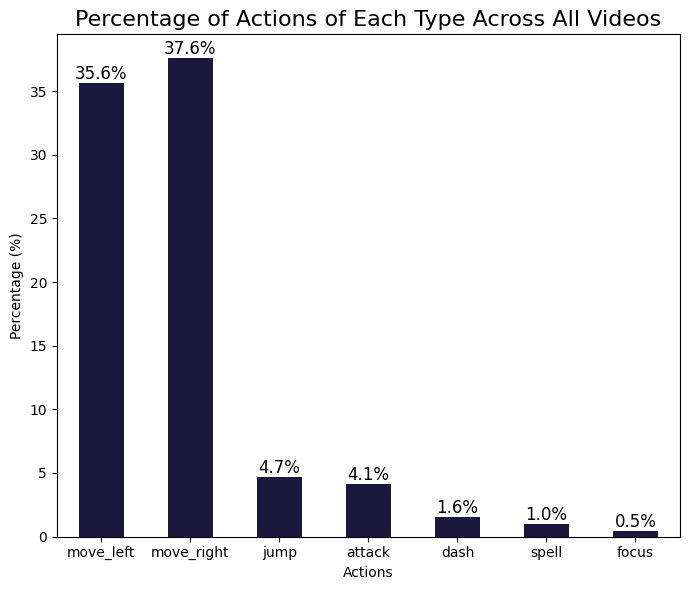

In [34]:
true_percentage = df[actions].mean() * 100

plt.figure(figsize=(7, 6))
ax = true_percentage.plot(kind='bar', color='#1B173D')
plt.title('Percentage of Actions of Each Type Across All Videos', fontsize=16)
plt.ylabel('Percentage (%)')
plt.xlabel('Actions')
plt.xticks(rotation=0)

for i, v in enumerate(true_percentage):
    ax.text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.savefig('./results/bar_plot.png', dpi=300)
plt.show()

In [7]:
def plot_image(i):
    frames = []
    video = cv2.VideoCapture('./data/dataset.mp4')
    video.set(cv2.CAP_PROP_POS_FRAMES, i-3)
    for _ in range(4):
        ret, frame = video.read()
        if not ret:
            break
        frames.append(frame)
    stacked_frame = np.hstack(frames) 

    plt.figure(figsize=(12, 6))
    plt.title(df.loc[i])
    plt.imshow(stacked_frame)
    plt.axis('off')
    plt.show()
    video.release()

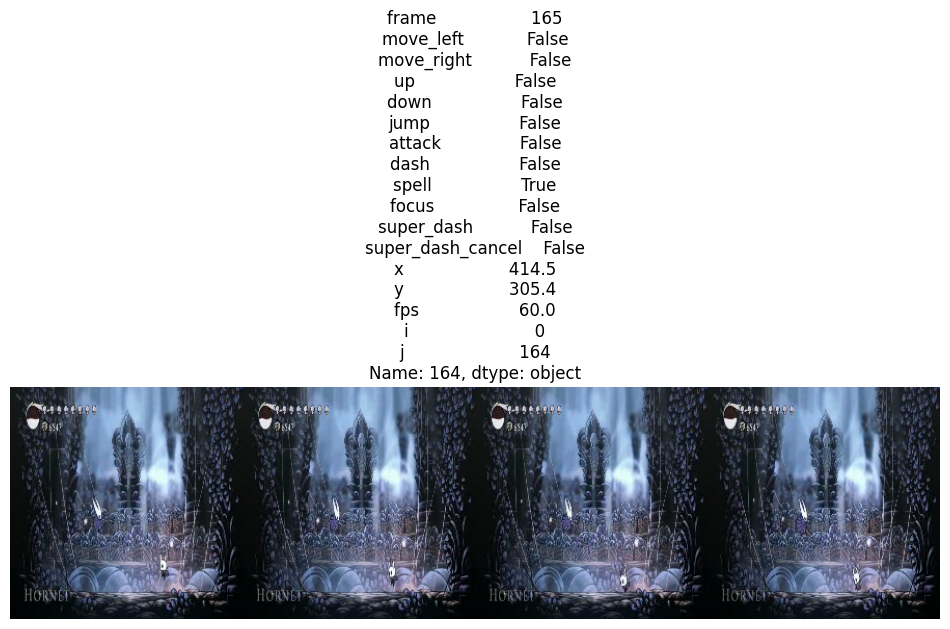

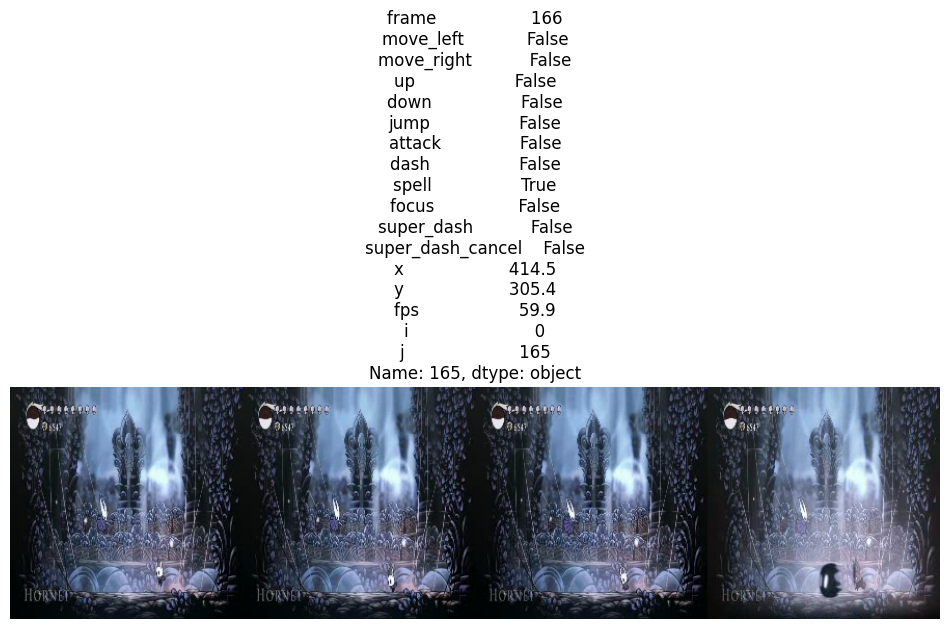

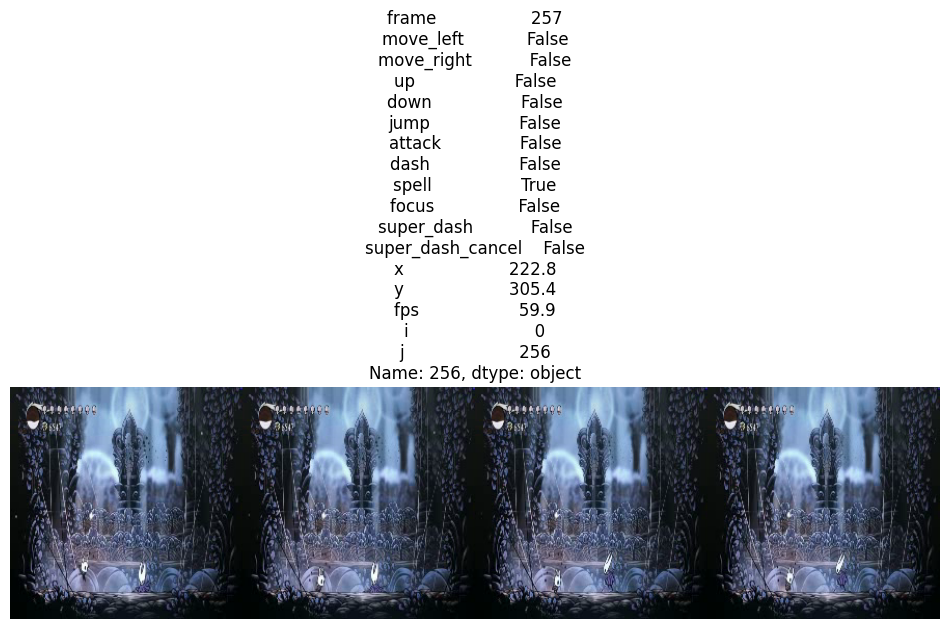

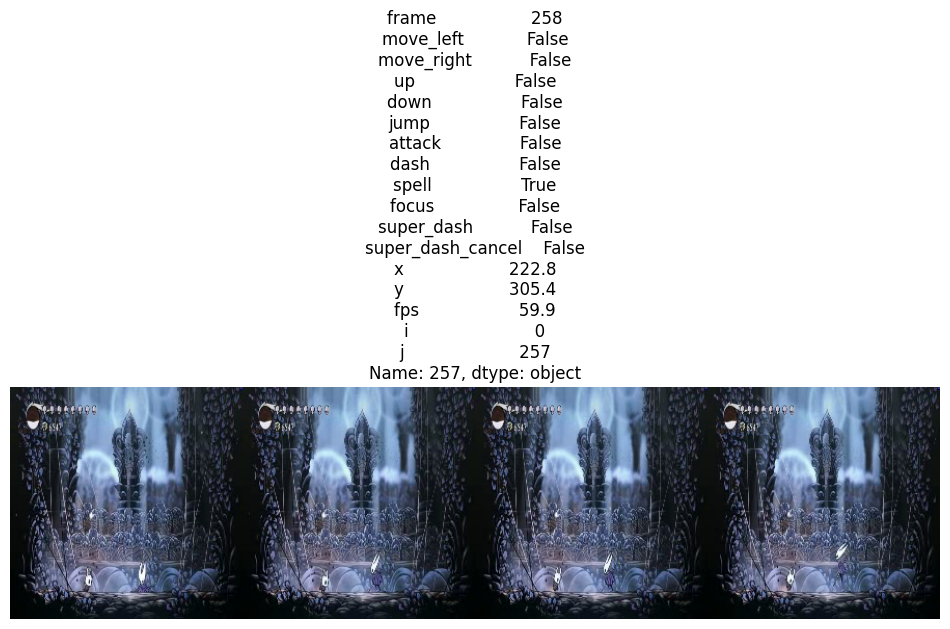

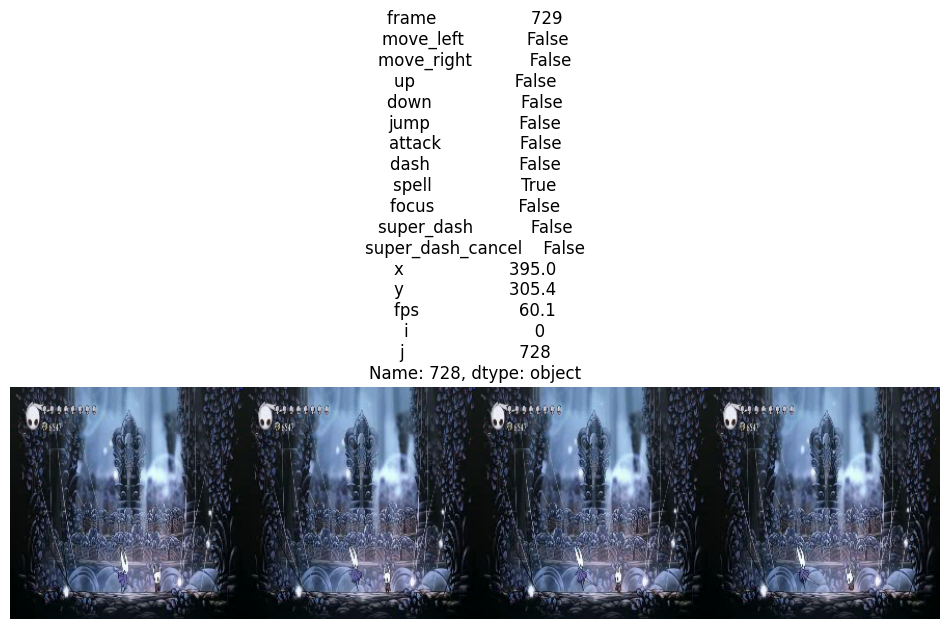

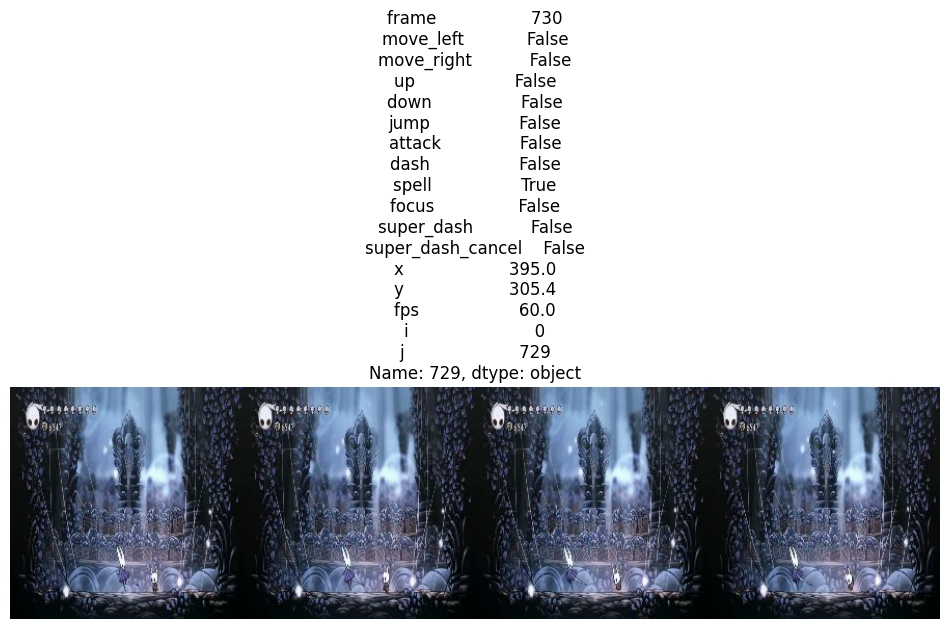

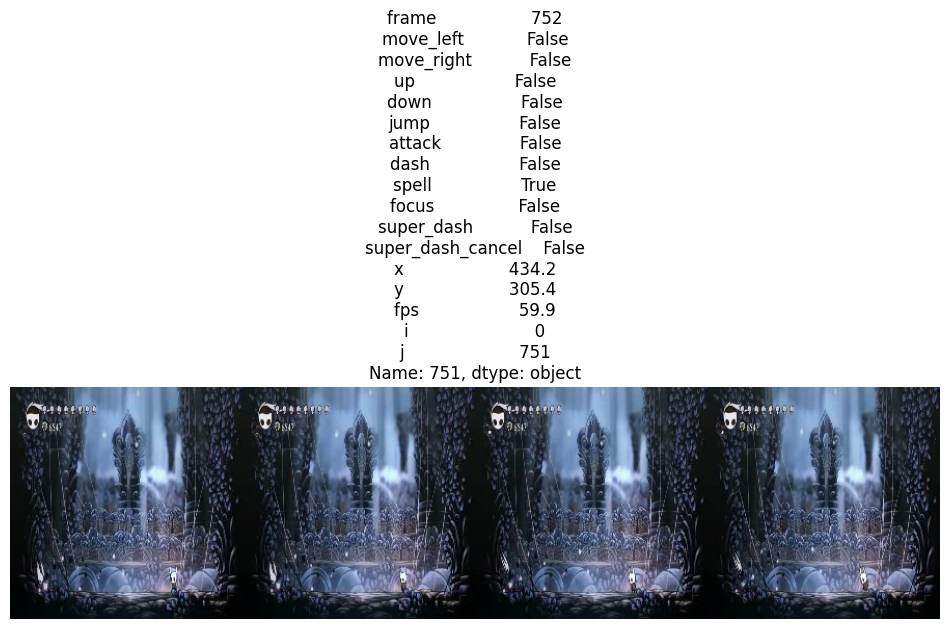

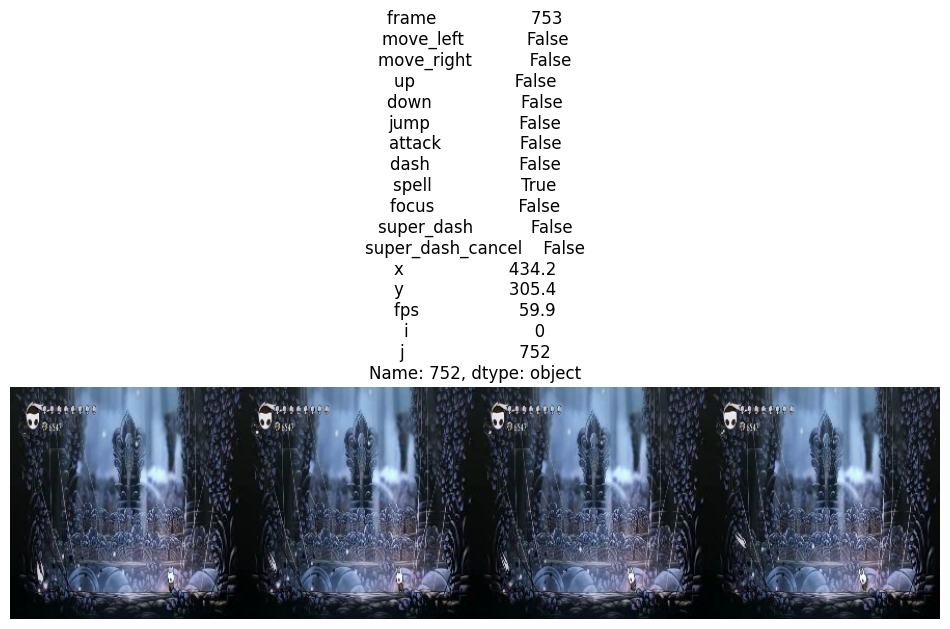

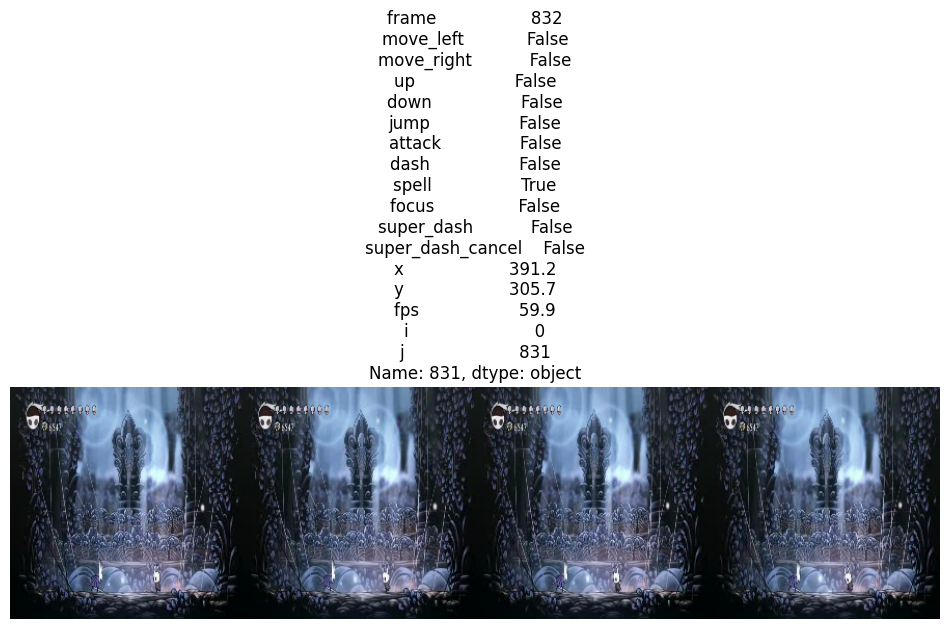

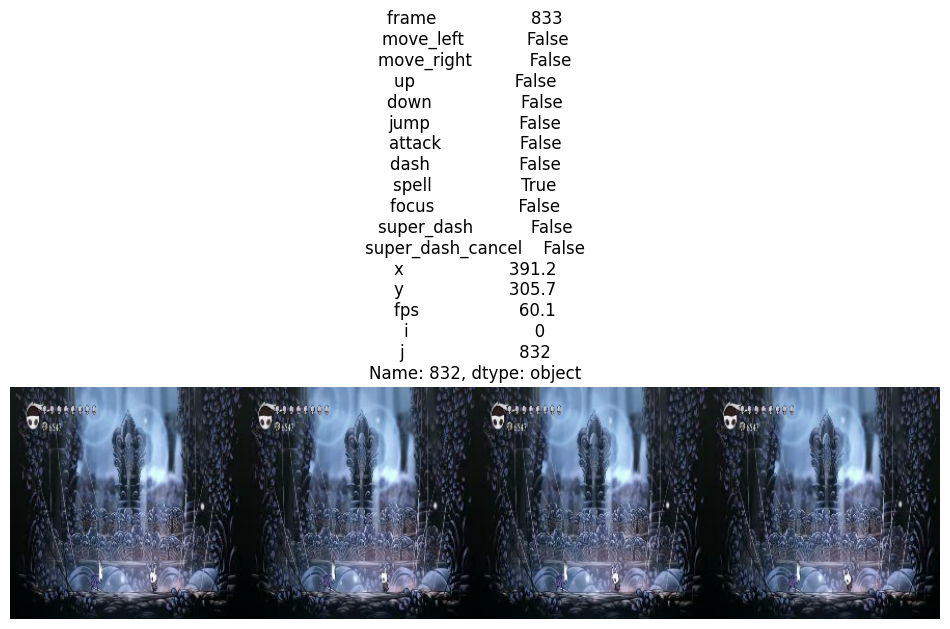

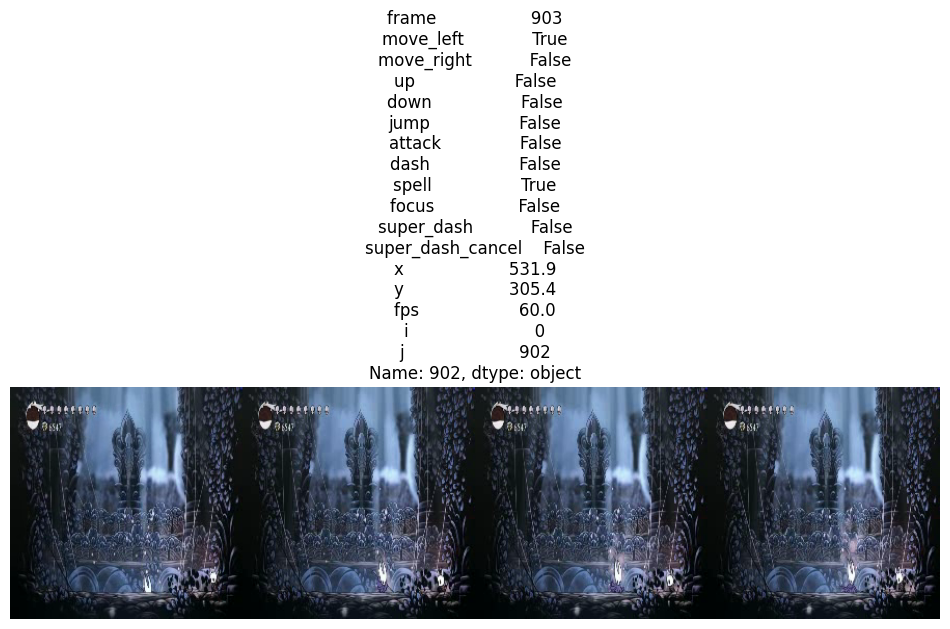

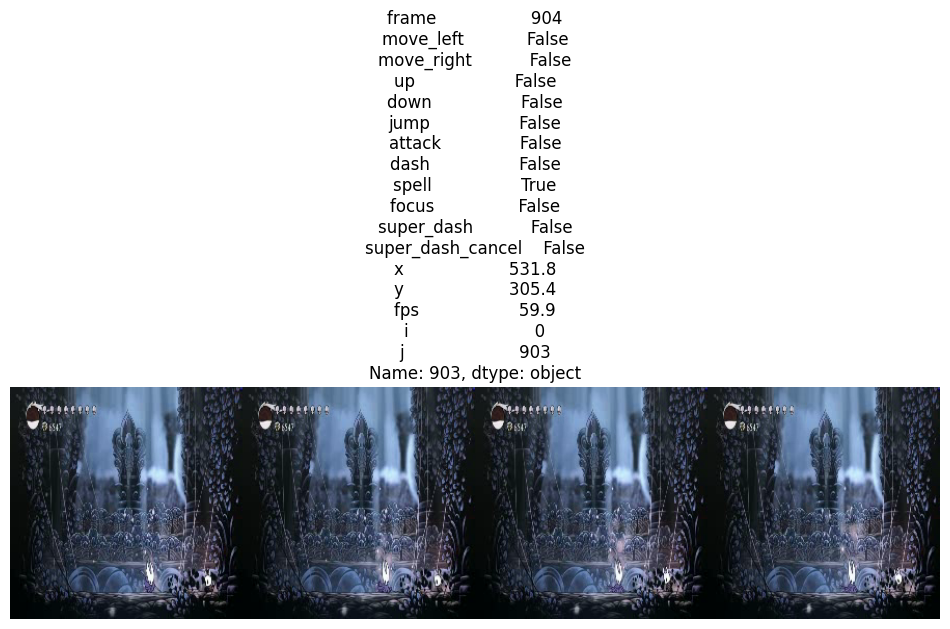

In [8]:
i = 0
while i<1000:    
    if df.loc[i]['spell']:
        plot_image(i)
    i += 1

# Training

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
df = pd.read_csv('./data/dataset-mantis.csv', index_col=0)
video = cv2.VideoCapture('./data/dataset-mantis.mp4')

In [11]:
ds = custom_dataset.LazyVideoDataset(video, df, actions, w=5)

In [12]:
batch_size = 16
train_dev_set, test_set = random_split(ds, [0.9, 0.1], generator=torch.Generator().manual_seed(29))
test_loader = DataLoader(test_set, batch_size=batch_size, pin_memory=True)
num_classes = len(actions)
learning_rate = 0.001

hidden_size = [256]
num_layers = [2]
weight_decay = 0.0
lstm_dropout = 0.2

bi = False
MAX_EPOCHS = 30
MAX_COUNTER = 5
k_folds = 5

In [7]:
def train(hidden_size, num_layers, num_classes, learning_rate, weight_decay, lstm_dropout, bi):
    s = f"hidden_size={hidden_size}, num_layers={num_layers}, num_classes={num_classes}, learning_rate={learning_rate}, weight_decay={weight_decay}, lstm_dropout={lstm_dropout}, bi={bi}"
    print(s)
    kfold = KFold(n_splits=k_folds, shuffle=True)
    
    metrics_per_fold = {}
    best_metrics_per_fold = {}
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dev_set)):
        print(f" === Fold {fold} === ")
        train_set = Subset(train_dev_set, train_ids)
        dev_set = Subset(train_dev_set, val_ids)
        
        train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=0, shuffle=True, pin_memory=True)
        dev_loader = DataLoader(dev_set, batch_size=batch_size, num_workers=0, shuffle=False, pin_memory=True)
        
        # Model
        model = models.ResnetModel(512, hidden_size, num_layers, num_classes, lstm_dropout=lstm_dropout, bi=bi).to(device)
        loss_fn = nn.BCEWithLogitsLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        print(model)
    
        # Metrics
        metrics = {
            'train' : {
                'loss' : [],
                'acc' : []
            },
            'validation' : {
                'loss' : [],
                'acc' : [],
            }
        }
        best_metrics =  {
            'epoch' : 0,
            'loss' : 1e8,
            'acc' : 0,
            'model' : model.state_dict()
        }
        
        epoch = 0
        counter = 0
        while epoch < MAX_EPOCHS and counter < MAX_COUNTER:
            start = time.time()
            # Training phase
            train_loss, train_acc = model_utils.train_step(model, train_loader, loss_fn, optimizer, device)
            metrics['train']['loss'].append(train_loss)
            metrics['train']['acc'].append(train_acc)
            
            # Validation phase
            val_loss, val_acc = model_utils.eval_step(model, dev_loader, loss_fn, device)
            metrics['validation']['loss'].append(val_loss)
            metrics['validation']['acc'].append(val_acc)
            end = time.time()
            
            if val_loss < best_metrics['loss']:
                best_metrics['epoch'] = epoch + 1
                best_metrics['loss'] = val_loss
                best_metrics['acc'] = val_acc
                best_metrics['model'] = model.state_dict()
                counter = 0
            else:
                counter += 1
        
            print(f"Epoch {epoch+1:03}/{MAX_EPOCHS}({end-start:,.2f} s)-Train loss: {train_loss:.7f}, Train acc: {100*train_acc:.4f}%, Validation loss: {val_loss:.7f}, Validation acc: {100*val_acc:.4f}%, C: {counter}")
            
            epoch += 1
        metrics_per_fold[fold] = metrics
        best_metrics_per_fold[fold] = best_metrics
        
        print(f" --- Best epoch {best_metrics['epoch']} --- ")
        print(f" --- Best loss {best_metrics['loss']} --- ")
        print(f" --- Best acc {best_metrics['acc']} --- ")
        torch.save(best_metrics['model'], f'./results/modelR7W5_{fold}_{s}.pt')
        if fold == 0:
            break
    
    # Save metrics
    with open(f'./results/metricsR7W5_{s}.json', 'w') as f:
        json.dump(metrics_per_fold, f, indent=4)

In [8]:
for h in hidden_size:
    for l in num_layers:
        train(h, l, num_classes, learning_rate, weight_decay, lstm_dropout, bi)

hidden_size=256, num_layers=2, num_classes=7, learning_rate=0.001, weight_decay=0.0, lstm_dropout=0.2, bi=False
 === Fold 0 === 
ResnetModel(
  (resnet18): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_

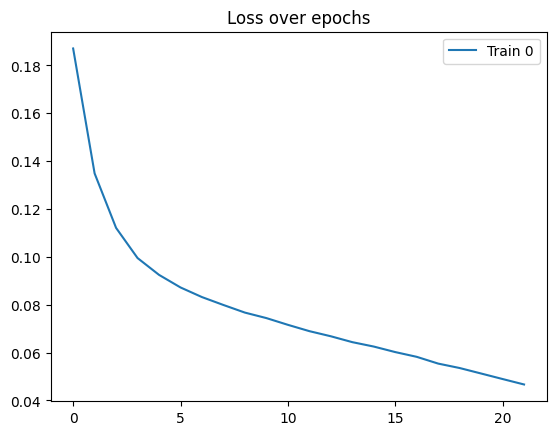

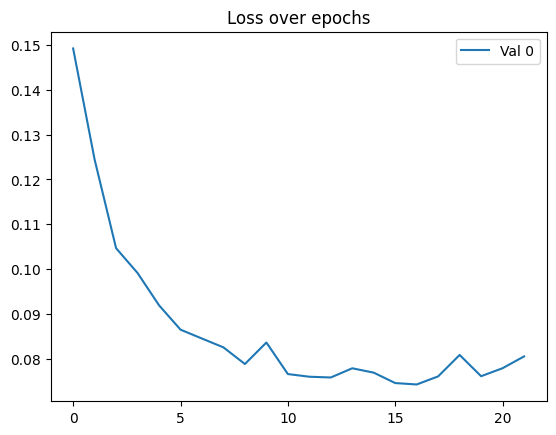

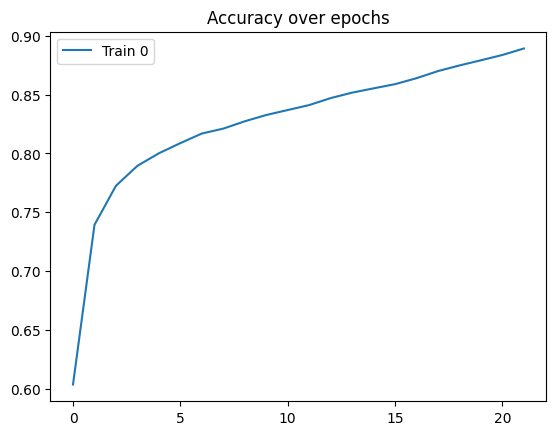

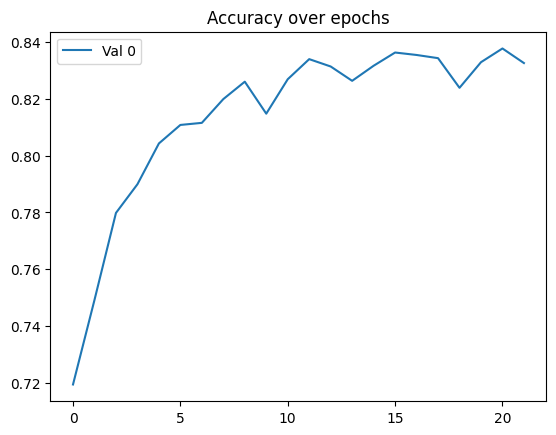

In [10]:
with open(f'./results/metricsR7W5_hidden_size=256, num_layers=2, num_classes=7, learning_rate=0.001, weight_decay=0.0, lstm_dropout=0.2, bi=False.json', 'r') as f:
    metrics_per_fold = json.load(f)

# Eval
for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['train']['loss'], label=f'Train {f}')
plt.legend()
plt.title("Loss over epochs")
plt.show()

for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['validation']['loss'], label=f'Val {f}')
plt.legend()
plt.title("Loss over epochs")
plt.show()

for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['train']['acc'], label=f'Train {f}')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

for f in metrics_per_fold:
    plt.plot(metrics_per_fold[f]['validation']['acc'], label=f'Val {f}')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

Accuracy: 82.59
              precision    recall  f1-score   support

   move_left       0.91      0.92      0.91      4601
  move_right       0.92      0.89      0.90      4815
        jump       0.80      0.77      0.78       661
      attack       0.61      0.46      0.53       551
        dash       0.98      0.83      0.90       218
       spell       0.67      0.48      0.56       127
       focus       0.97      1.00      0.98        60

   micro avg       0.89      0.87      0.88     11033
   macro avg       0.84      0.77      0.80     11033
weighted avg       0.89      0.87      0.88     11033
 samples avg       0.92      0.91      0.86     11033



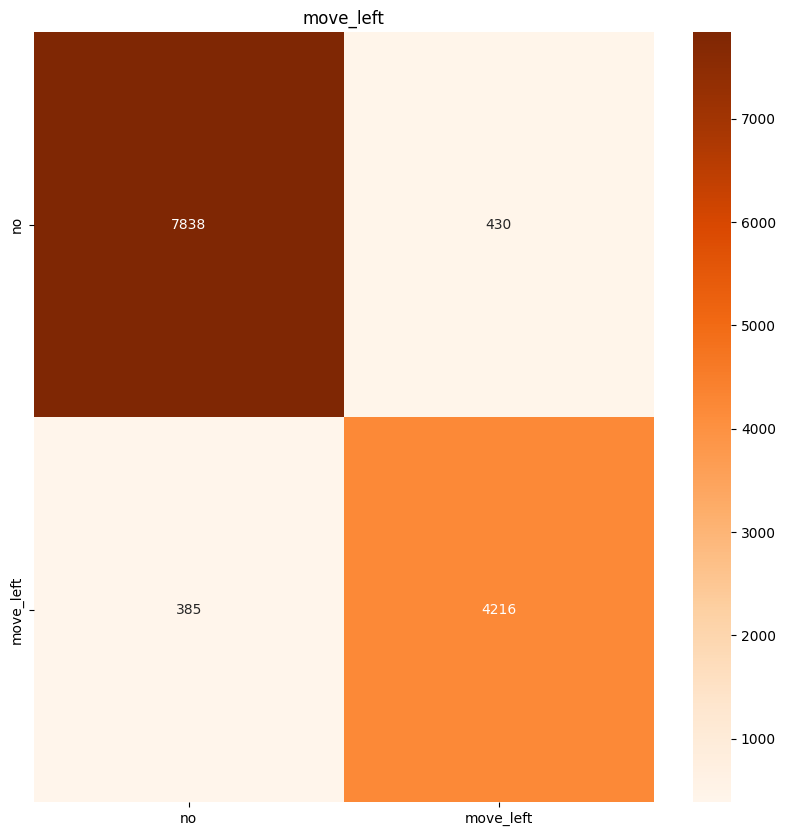

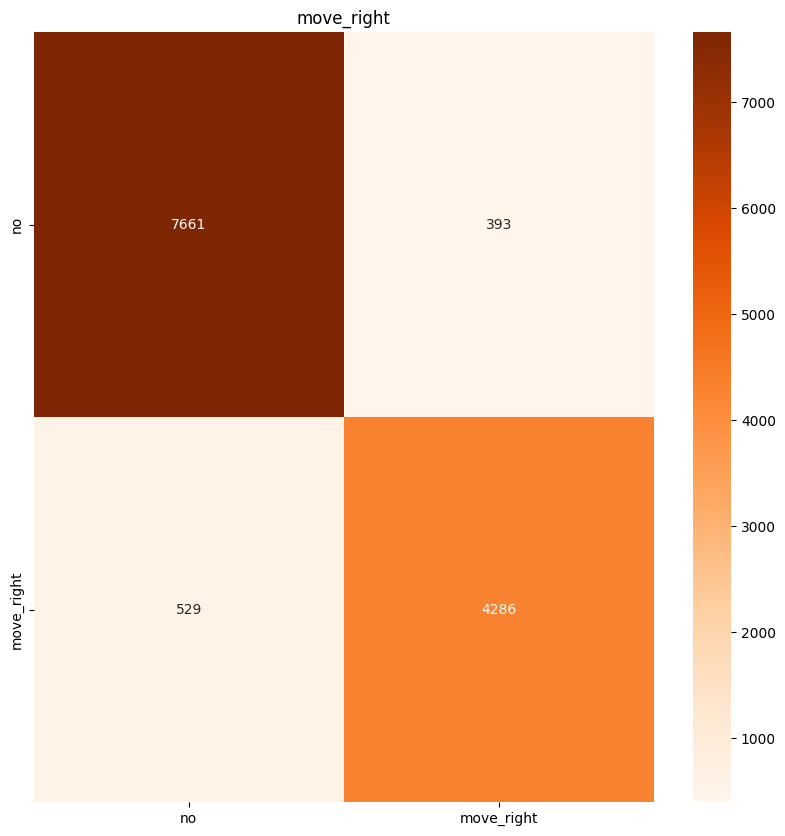

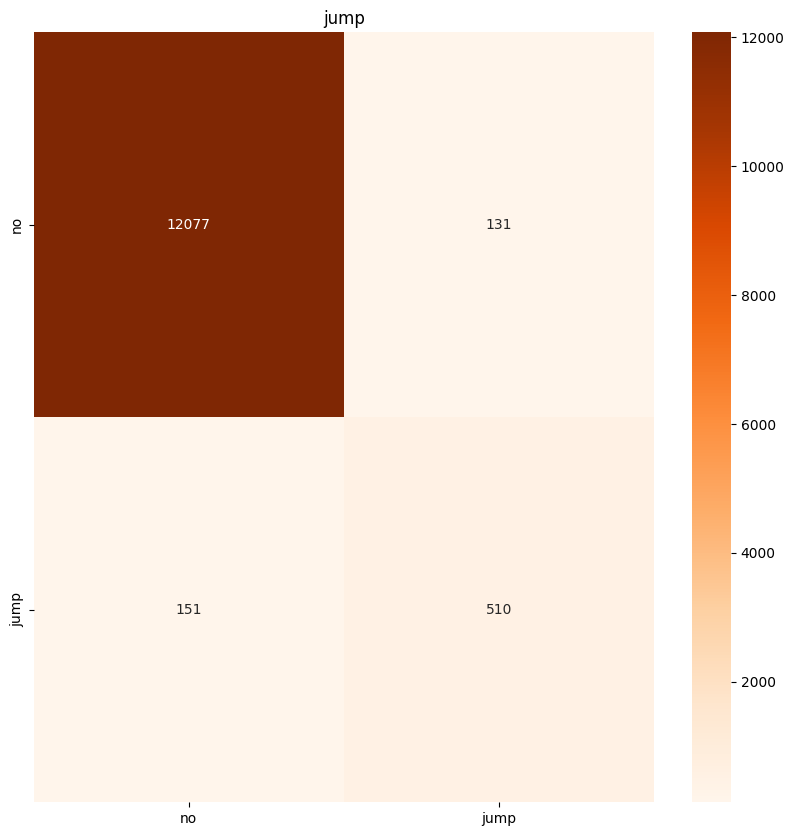

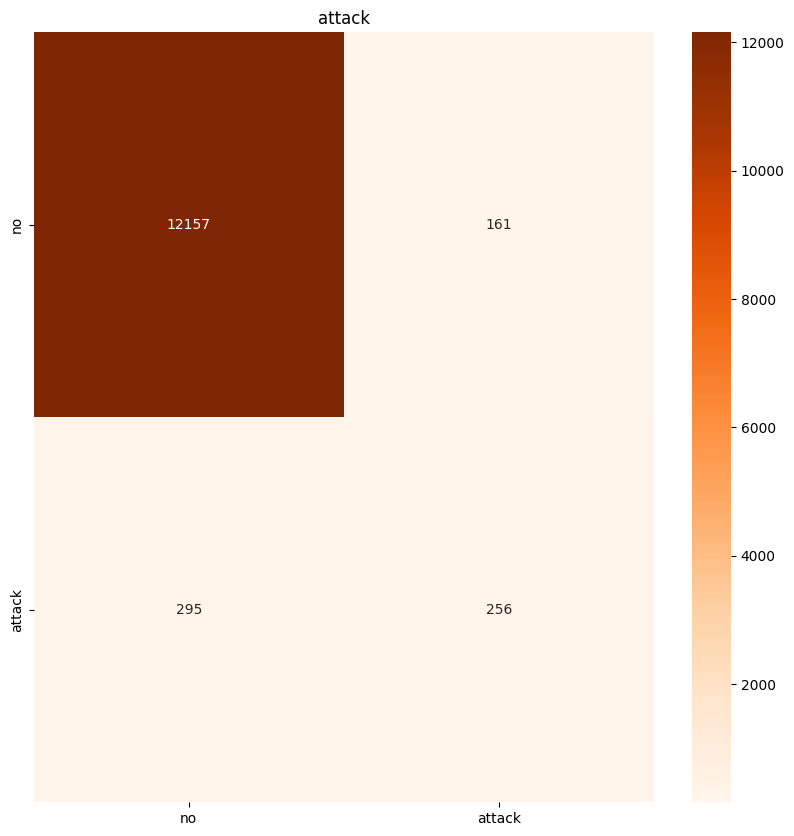

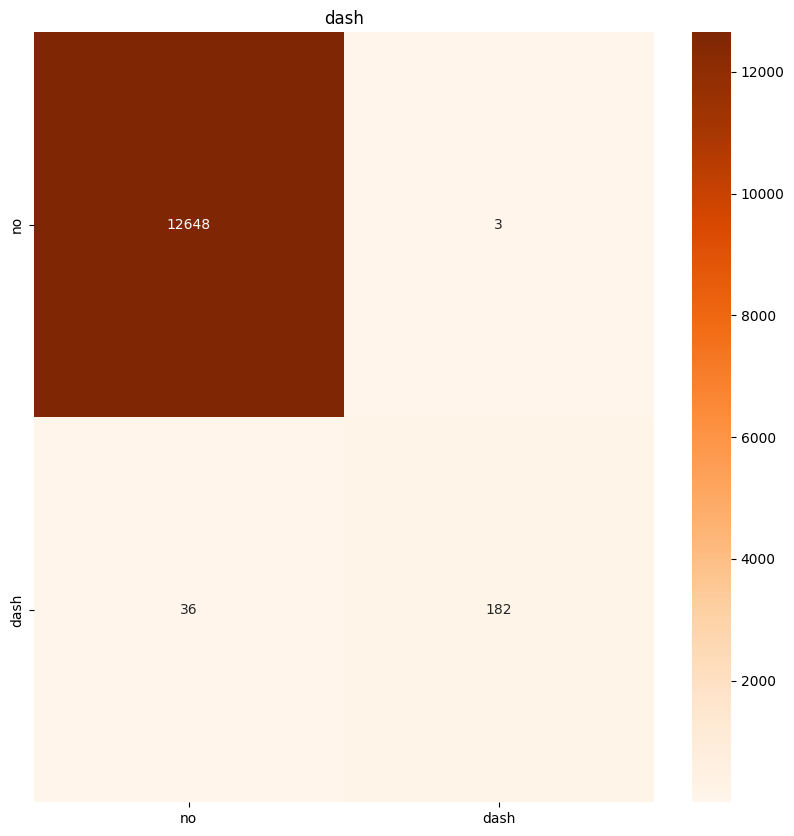

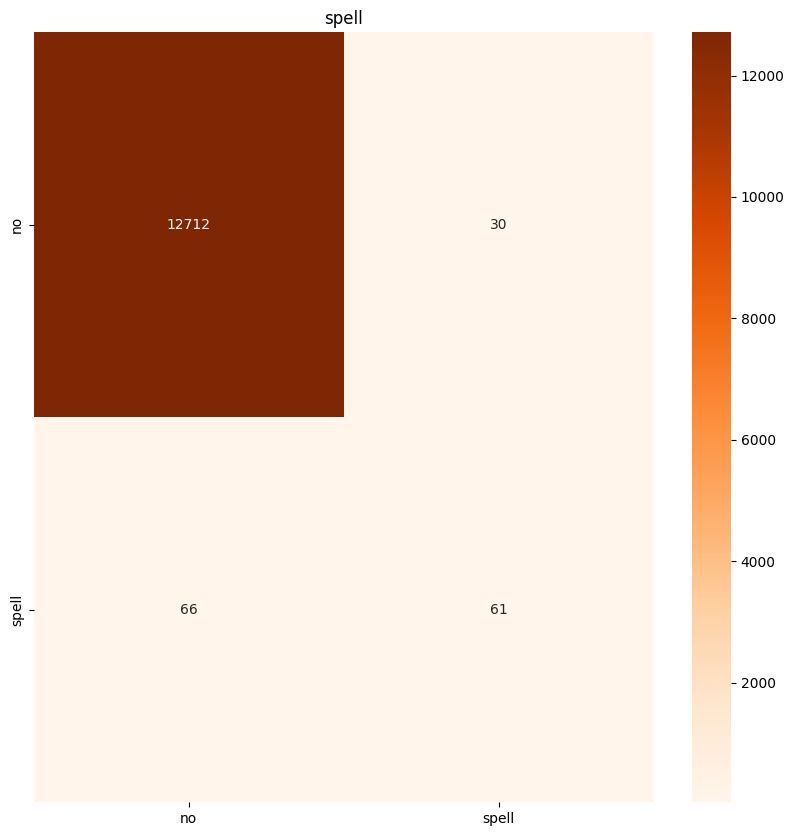

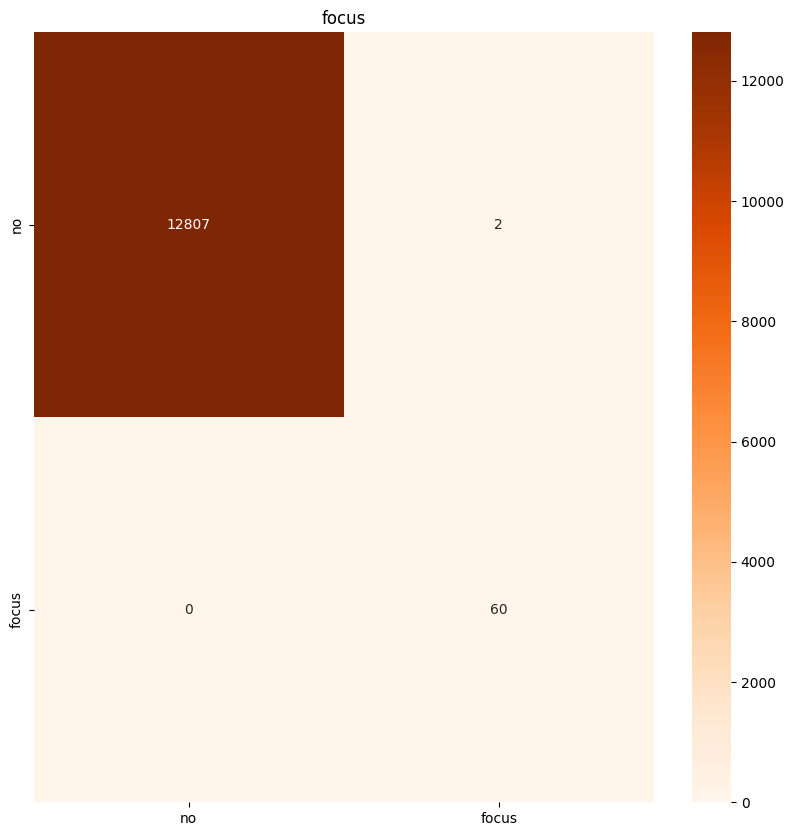

In [11]:
best_fold = 0
best_model_w = torch.load(f'./results/modelR7W5_0_hidden_size=256, num_layers=2, num_classes=7, learning_rate=0.001, weight_decay=0.0, lstm_dropout=0.2, bi=False.pt', weights_only=True)
best_model = models.ResnetModel(512, 256, 2, 7, lstm_dropout=0.2, bi=bi).to(device)
best_model.load_state_dict(best_model_w)
train_pred, train_labels = model_utils.eval_multilabel(best_model, test_loader, actions=actions)

# Fine tuning

## Dataset

In [19]:
df = pd.read_csv('./data/dataset.csv', index_col=0)
video = cv2.VideoCapture('./data/dataset.mp4')

In [38]:
new_df = []
for action in ['move_left', 'move_right', 'jump', 'attack', 'dash', 'spell']:
    new_df.append(df.loc[df[action] == True].sample(n=1200, random_state=29))
new_df = pd.concat(new_df)
new_df = new_df.drop_duplicates()
new_df.to_csv('./data/dataset-ft.csv')
new_df.shape

(7131, 17)

In [37]:
video_df = cv2.VideoWriter('./data/dataset-ft.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (224, 224))
for row in new_df.itertuples():
    video.set(cv2.CAP_PROP_POS_FRAMES, row.Index-3)
    for i in range(3):
        _, frame = video.read()
        assert(_)
        resized_frame = cv2.resize(frame, (224, 224))
        video_df.write(resized_frame)
video_df.release()

## Training

In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
df = pd.read_csv('./data/dataset-ft.csv', index_col=0)
video = cv2.VideoCapture('./data/dataset-ft.mp4')
ds = custom_dataset.LazyVideoDataset(video, df, actions, w=3)

In [51]:
len(ds)

7131

In [54]:
kfold = KFold(n_splits=5, shuffle=True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(ds)):
    print(f" === Fold {fold} === ")
    train_set = Subset(ds, train_ids)
    dev_set = Subset(ds, val_ids)
    
    train_loader = DataLoader(train_set, batch_size=32, num_workers=0, shuffle=True, pin_memory=True)
    dev_loader = DataLoader(dev_set, batch_size=32, num_workers=0, shuffle=False, pin_memory=True)
    
    # Model
    best_model_w = torch.load(f'./results/modelR5_0_hidden_size=256, num_layers=2, num_classes=7, learning_rate=0.001, weight_decay=0.0, lstm_dropout=0.2, bi=False.pt', weights_only=True)
    best_model = models.ResnetModel(512, 256, 2, 7, lstm_dropout=0.2, bi=False).to(device)
    best_model.load_state_dict(best_model_w)   
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(best_model.parameters(), lr=0.0001)

    best_loss = 1e8
    epoch = 0
    counter = 0
    while epoch < 10 and counter < 4:
        start = time.time()
        # Training phase
        train_loss, train_acc = model_utils.train_step(best_model, train_loader, loss_fn, optimizer, device)
        
        # Validation phase
        val_loss, val_acc = model_utils.eval_step(best_model, dev_loader, loss_fn, device)
        end = time.time()
        
        if val_loss < best_loss:
            torch.save(best_model.state_dict(), f'./results/modelR5-FT-{epoch}.pt')
            best_loss = val_loss
            counter = 0
        else:
            counter += 1
    
        print(f"Epoch {epoch+1:03}/{20}({end-start:,.2f} s)-Train loss: {train_loss:.7f}, Train acc: {100*train_acc:.4f}%, Validation loss: {val_loss:.7f}, Validation acc: {100*val_acc:.4f}%, C: {counter}")
        epoch += 1
    break

 === Fold 0 === 
Epoch 001/20(52.26 s)-Train loss: 0.1108945, Train acc: 78.7693%, Validation loss: 0.0786115, Validation acc: 84.5130%, C: 0
Epoch 002/20(51.87 s)-Train loss: 0.0803253, Train acc: 83.2924%, Validation loss: 0.0681894, Validation acc: 86.0547%, C: 0
Epoch 003/20(51.14 s)-Train loss: 0.0696909, Train acc: 85.3261%, Validation loss: 0.0650469, Validation acc: 86.7554%, C: 0
Epoch 004/20(51.32 s)-Train loss: 0.0627071, Train acc: 86.5007%, Validation loss: 0.0634008, Validation acc: 87.1058%, C: 0
Epoch 005/20(51.36 s)-Train loss: 0.0575511, Train acc: 87.4123%, Validation loss: 0.0624494, Validation acc: 87.2460%, C: 0
Epoch 006/20(51.44 s)-Train loss: 0.0531436, Train acc: 88.5694%, Validation loss: 0.0622330, Validation acc: 86.8956%, C: 0
Epoch 007/20(51.58 s)-Train loss: 0.0489914, Train acc: 89.0603%, Validation loss: 0.0628473, Validation acc: 87.2460%, C: 1
Epoch 008/20(51.54 s)-Train loss: 0.0456317, Train acc: 90.0245%, Validation loss: 0.0623966, Validation acc